# Time Series Analysis

<img src="photo.jpg" style="width:100%;height:450px"/>

# Machine Learning, Deep Learning forecasting technique for machine operators.

Objective: Machines shop produces  products  and machine operators are the personnel who service, operate and monitor products  every hour visually and size check every hour. To stop a  machine at the right size and not to oversize , not to undersize products, machine operators use common sense calculating in mind  using experience as historical data to predict time when a machine is done. What if Machine Learning models or Deep Learning models would be used instead? What if to teach a machine to predict when it should be stopped inputting historical data in it and forecast?There are algorithms that already can do this job for the industry:ARIMA, LSTM, even Facebook Prophet which Facebook developed for this purpose.Techniques of time series forecasting could answer business questions like how much inventory to maintain, how much website traffic do you expect in your e-store to how many product will be sold in the next month.
This project is an attempt to simulate  a situation and to extract a conclusion from the experiment.

The dataset is engineered for simplicity of the experiment as simple and meaningful as  possible to provide enough information for the algorithm to compute its forecast and ready to use without data wrangling.


# ARIMA Approach

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [3]:
# Import Train and Test Data 
source  = '/Users/Administrator/Desktop/' 
datafile = pd.read_csv(source + 'MLMachines.csv')
#columns = ['Basic_Size','Gr','Target_Pull_Size']
chart = pd.DataFrame(datafile)
chart.insert(8, "Mach#", [21, 23, 24, 25,26,27,28,29,30,31], True) 
table = chart.pivot_table(
        values=['size2','size3','size4'], 
        index=['Basic_Size', 'Gr','Mach#'], 
        columns='Time')

table
#pivotdf  = chart.pivot(index = 'Basic_Size', columns ='Time')

#pivotdf = chart.set_index('Gr').stack().groupby(level=[0,1]).value_counts().unstack(level=[1,2]).fillna(0).sort_index(axis=1)
    
#pivotdf

size2                                              \
Time                2021-01-01 2021-01-02 2021-01-03 2021-01-04 2021-01-05   
Basic_Size Gr Mach#                                                          
11/32      25 25           NaN        NaN        NaN     0.0008        NaN   
13/32      25 28           NaN        NaN        NaN        NaN        NaN   
3/16       10 21        0.0009        NaN        NaN        NaN        NaN   
           25 29           NaN        NaN        NaN        NaN        NaN   
3/8        10 27           NaN        NaN        NaN        NaN        NaN   
5/16       10 24           NaN        NaN     0.0008        NaN        NaN   
           25 31           NaN        NaN        NaN        NaN        NaN   
5/32       25 23           NaN    0.00085        NaN        NaN        NaN   
              30           NaN        NaN        NaN        NaN        NaN   
5/8        24 26           NaN        NaN        NaN        NaN     0.0007   

                                                                            \
Time                2021-01-06 2021-01-07 2021-01-08 2021-01-09 2021-01-10   
Basic_Size Gr Mach#                                                          
11/32      25 25           NaN        NaN        NaN        NaN        NaN   
13/32      25 28           NaN     0.0006        NaN        NaN        NaN   
3/16       10 21           NaN        NaN        NaN        NaN        NaN   
           25 29           NaN        NaN     0.0006        NaN        NaN   
3/8        10 27        0.0007        NaN        NaN        NaN        NaN   
5/16       10 24           NaN        NaN        NaN        NaN        NaN   
           25 31           NaN        NaN        NaN        NaN     0.0005   
5/32       25 23           NaN        NaN        NaN        NaN        NaN   
              30           NaN        NaN        NaN     0.0005        NaN   
5/8        24 26           NaN        NaN        NaN        NaN        NaN   

                     ...      size4                                   \
Time                 ... 2021-01-01 2021-01-02 2021-01-03 2021-01-04   
Basic_Size Gr Mach#  ...                                               
11/32      25 25     ...        NaN        NaN        NaN     0.0003   
13/32      25 28     ...        NaN        NaN        NaN        NaN   
3/16       10 21     ...     0.0007        NaN        NaN        NaN   
           25 29     ...        NaN        NaN        NaN        NaN   
3/8        10 27     ...        NaN        NaN        NaN        NaN   
5/16       10 24     ...        NaN        NaN     0.0003        NaN   
           25 31     ...        NaN        NaN        NaN        NaN   
5/32       25 23     ...        NaN     0.0003        NaN        NaN   
              30     ...        NaN        NaN        NaN        NaN   
5/8        24 26     ...        NaN        NaN        NaN        NaN   

                                                                            \
Time                2021-01-05 2021-01-06 2021-01-07 2021-01-08 2021-01-09   
Basic_Size Gr Mach#                                                          
11/32      25 25           NaN        NaN        NaN        NaN        NaN   
13/32      25 28           NaN        NaN    0.00002        NaN        NaN   
3/16       10 21           NaN        NaN        NaN        NaN        NaN   
           25 29           NaN        NaN        NaN   -0.00007        NaN   
3/8        10 27           NaN    0.00011        NaN        NaN        NaN   
5/16       10 24           NaN        NaN        NaN        NaN        NaN   
           25 31           NaN        NaN        NaN        NaN        NaN   
5/32       25 23           NaN        NaN        NaN        NaN        NaN   
              30           NaN        NaN        NaN        NaN   -0.00016   
5/8        24 26        0.0002        NaN        NaN        NaN        NaN   

                                
Time      

### Preparing the dataset for Time Series

In [40]:
from datetime import datetime
chart['Time']=pd.to_datetime(chart['Time'])

In [41]:
date_time = chart['Time']

### Time Series by Components

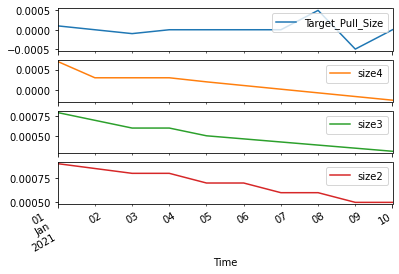

In [42]:
plot_cols = ['Target_Pull_Size', 'size4', 'size3','size2']
plot_features = chart[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [43]:

tb=chart.set_index(['Time'])
tb.head()

,Basic_Size,Start_Size,size2,size3,size4,Gr,Target_Pull_Size,Mach#
Time,,,,,,,,
2021-01-01,3/16,0.00100,0.00090,0.0008,0.0007,10,0.0001,21
2021-01-02,5/32,0.00060,0.00085,0.0007,0.0003,25,0.0000,23
2021-01-03,5/16,0.00090,0.00080,0.0006,0.0003,10,-0.0001,24
2021-01-04,11/32,0.01200,0.00080,0.0006,0.0003,25,0.0000,25
2021-01-05,5/8,0.01195,0.00070,0.0005,0.0002,24,0.0000,26


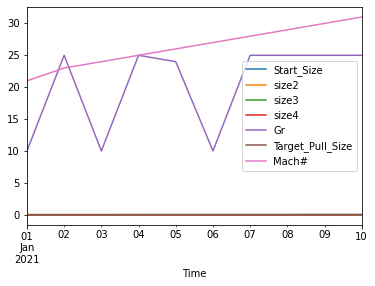

In [44]:
tb.plot()

#### X  and Y regressors and predictors.

In [45]:
#x and y axes input data
y = tb['size4']
x =  tb.drop(['size4'], axis = 1)

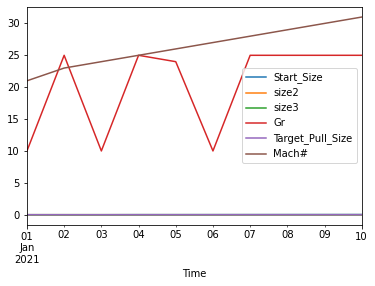

In [46]:
x.plot()

Peeking at how  Y data  trend behaves

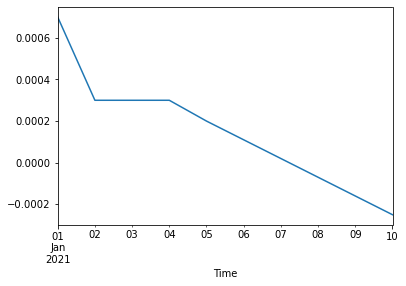

In [47]:
y.plot()

When doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the p-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary

In [48]:
from statsmodels.tsa.stattools import kpss
kpss(y,nlags='legacy')

(0.41437069813175986,
 0.07096090597768973,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [6]:
#preprocessing 
from sklearn.preprocessing import OneHotEncoder
traindfcat = x.select_dtypes(include ='object') 
enc = OneHotEncoder(sparse=False)
X_transfCat = enc.fit_transform(traindfcat)

### The ARIMA model

ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the sklearn and statsmodels libraries, and in particular mean_squared_error and ARIMA.

In [49]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

Make a function to find the MSE of a single ARIMA model¶

In [50]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

Make a function to evaluate the different ARIMA models with different p, d, and q values

In [51]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [52]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [53]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
Best ARIMA(0, 1, 1) MSE=0.000


In [54]:
p=0
d=1
q=1
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [55]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.size4   No. Observations:                    9
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  71.293
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sun, 07 Feb 2021   AIC                           -136.586
Time:                        21:05:29   BIC                           -135.994
Sample:                    01-02-2021   HQIC                          -137.862
                         - 01-10-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.818e-05   8.51e-06    -10.366      0.000      -0.000   -7.15e-05
ma.L1.D.size4    -0.9996      0.298     -3.353      0.001      -1.584      -0.415
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0004           +0.0000j            1.0004            0.0000
-----------------------------------------------------------------------------
"""

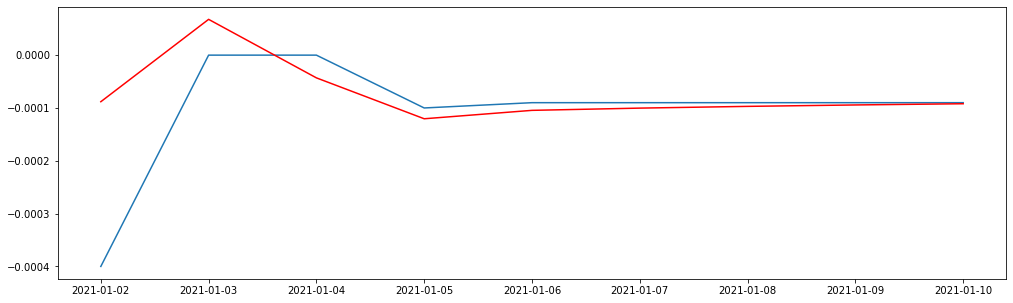

In [56]:
import matplotlib as plt

from matplotlib import *
import sys
import pylab as pl
pl.figure( figsize =(17,5) )
pl.plot(y.diff())
pl.plot(model_fit.predict(),color='red')

Model fits pretty closely to our actual data. 

#### Application: Forecasting

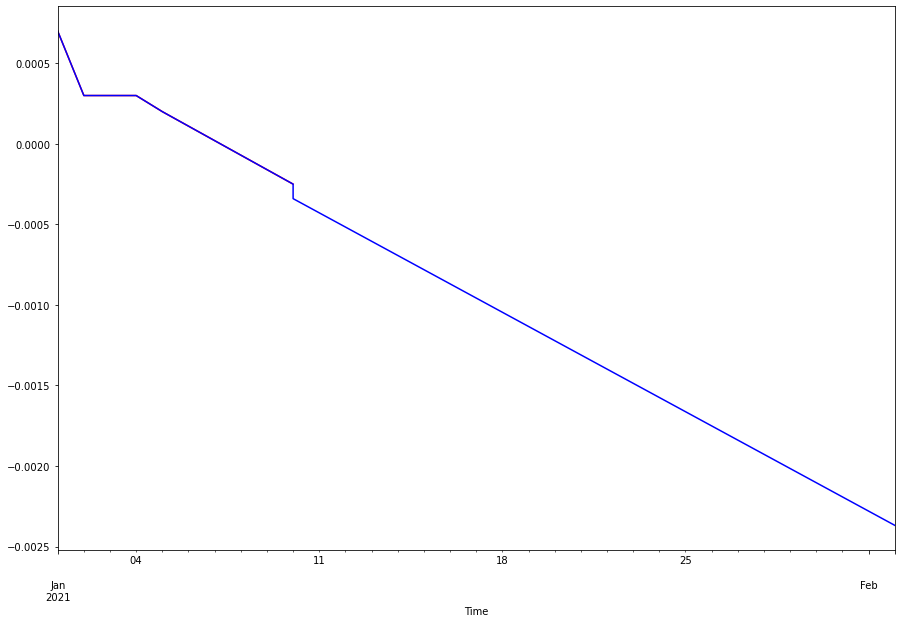

In [66]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
from matplotlib import *
import sys
import pylab as pl
forecast_period = 24
date_range = pd.date_range(y.index[-1], periods = forecast_period, 
              freq='D').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions

future_months = pd.DataFrame(date_range, columns = ['Day'])
future_months['Day'] = pd.to_datetime(future_months['Day'])
future_months.set_index('Day', inplace = True)
future_months['Prediction'] = forecast[0]
yforcast = y.append(future_months['Prediction'])
# Plot your future predictions
pl.figure(figsize=(15,10))


ax = y.plot(color = 'red', label = 'Real')

yforcast.plot(ax=ax,color = 'blue', label = 'Real')
pl.show()

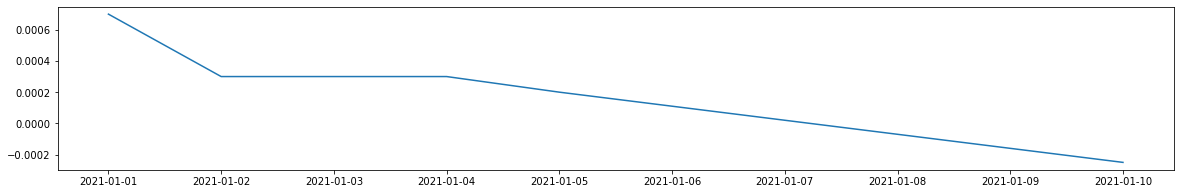

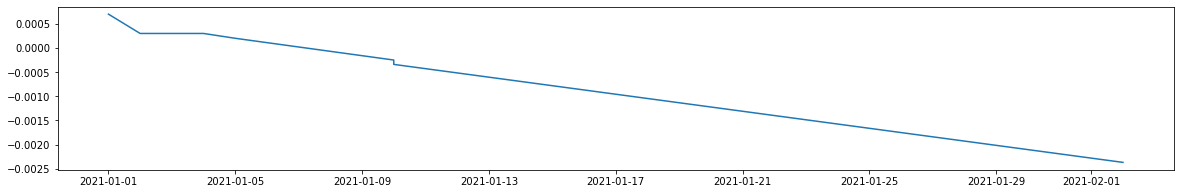

In [68]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
fig1 = plt.figure()
fig2 = plt.figure()

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)

ax1.plot(y)
ax2.plot(yforcast)

plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# calculate out of sample error
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    rmse = sqrt(error)
    return rmse


In [29]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s MSE=%.3f' % (order,rmse))
                except:
                    continue
    return print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [30]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
Best ARIMA(0, 1, 1) RMSE=0.000


# Facebook Prophet Approach

In [3]:
# Import Train and Test Data 
source  = '/Users/Administrator/Desktop/' 
datafile = pd.read_excel(source + 'FBdataset.xlsx')
#columns = ['Basic_Size','Gr','Target_Pull_Size']
data = pd.DataFrame(datafile)

In [5]:
data
#df = chart.drop(['Basic_Size','Start_Size','size2','size3','Gr', 'Target_Pull_Size','size4','Mach#','Time'], axis = 1)

,y,ds
0,0.000700,2021-01-01
1,0.000300,2021-01-02
2,0.000300,2021-01-03
3,0.000300,2021-01-04
4,0.000200,2021-01-05
5,0.000110,2021-01-06
6,0.000020,2021-01-07
7,-0.000070,2021-01-08
8,-0.000160,2021-01-09
9,-0.000250,2021-01-10


In [7]:
#x and y axes input data
y =  data['y']
ds = data['ds']


In [11]:
datarev = data[data.columns[::-1]]
datarev

,ds,y
0,2021-01-01,0.000700
1,2021-01-02,0.000300
2,2021-01-03,0.000300
3,2021-01-04,0.000300
4,2021-01-05,0.000200
5,2021-01-06,0.000110
6,2021-01-07,0.000020
7,2021-01-08,-0.000070
8,2021-01-09,-0.000160
9,2021-01-10,-0.000250


In [12]:
from datetime import datetime
datarev['ds']=pd.to_datetime(datarev['ds'])

In [13]:
from matplotlib import *
import sys
import pylab as pl
from fbprophet import Prophet

model=Prophet()




Importing plotly failed. Interactive plots will not work.


In [ ]:
model.fit(datarev)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
C:\Users\Administrator\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [14]:
future = m.make_future_dataframe(periods=365)
future.tail()

AttributeError: 'numpy.ndarray' object has no attribute 'set_index'

In [12]:
future = model.make_future_dataframe(periods=365)
future.tail()

Exception: Model has not been fit.

In [6]:
# Python
fig1 = model.plot(forecast)


NameError: name 'forecast' is not defined

In [ ]:
 #Python
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
# Python
fig1 = m.plot(forecast)


In [ ]:
# Python
fig2 = m.plot_components(forecast)


In [ ]:
# Python
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

# LSTM Model Approach

I needed to reshape input data to transform it into Nueral networks compatible

In [78]:
#x and y axes input data
y = tb['size4']
x =  tb.drop(['size4','Basic_Size', 'Gr'], axis = 1)
x.transpose()

Time,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10
Start_Size,0.0010,0.00060,0.0009,0.0120,0.01195,0.01528,0.01861,0.02194,0.02527,0.0286
size2,0.0009,0.00085,0.0008,0.0008,0.00070,0.00070,0.00060,0.00060,0.00050,0.0005
size3,0.0008,0.00070,0.0006,0.0006,0.00050,0.00046,0.00042,0.00038,0.00034,0.0003
Target_Pull_Size,0.0001,0.00000,-0.0001,0.0000,0.00000,0.00000,0.00000,0.00050,-0.00050,0.0000
Mach#,21.0000,23.00000,24.0000,25.0000,26.00000,27.00000,28.00000,29.00000,30.00000,31.0000


In [79]:
Xx = np.array(x)
Yy = np.array(y)

Here is the model itself

In [83]:

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense 
from keras.callbacks import EarlyStopping

x_train = np.expand_dims(Xx, 1)
# define model
model = Sequential()
model.add(LSTM(1, input_shape=(1,5), activation='relu', return_sequences=True))
model.add(LSTM(1,input_shape=(1,5)))
model.compile(optimizer='adam', loss='mse')

In [84]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 1)              28        
_________________________________________________________________
lstm_8 (LSTM)                (None, 1)                 12        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
#fitting the model
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)
history = model.fit(x_train, y , batch_size = 10240, epochs = 100, verbose = False,validation_split=0.3,callbacks=[early_stopping_monitor])


In [86]:
#output the forecasted data
yhat = model.predict(x_train, verbose=0)
print(yhat)

[[ 4.6303147e-03]
 [ 3.4735538e-03]
 [ 2.8819600e-03]
 [ 2.1633385e-03]
 [ 1.6045889e-03]
 [ 1.0231979e-03]
 [ 4.6464367e-04]
 [-6.4008374e-05]
 [-5.8298826e-04]
 [-1.0600494e-03]]


In [87]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(y, yhat)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.001987


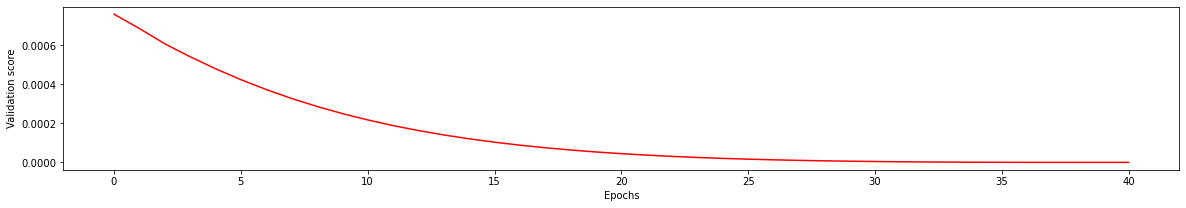

In [88]:
#visualise how the model trains itself
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Create the plot
plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

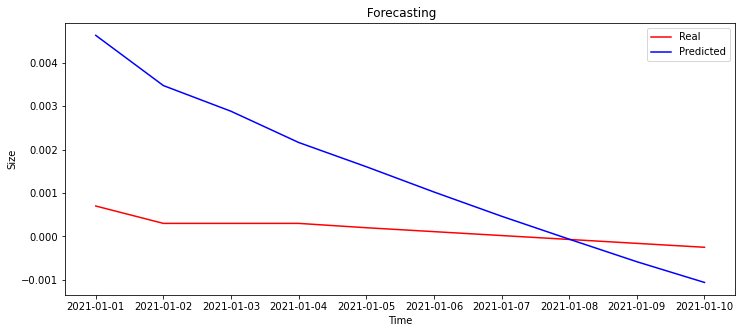

In [92]:
# Visualising the results
import matplotlib as plt

from matplotlib import *
import sys
import pylab as pl
pl.figure( figsize =(12,5) )
pl.plot(y, color = 'red', label = 'Real')
pl.plot(x.index, yhat, color = 'blue', label = 'Predicted')
pl.title(' Forecasting')
pl.xlabel('Time')
pl.ylabel('Size')
pl.legend()
pl.show()

### Evaluating and Concluding

This was a valuable experience. I found out that Facebook Prophet has a contraint to input data: two variables only. I Learned details about buildong ARIMA and LSTM . I dd not like Facebook Prophet as it can take only two varuable to compute forcasting. It also need more attention to parameters. In m case I would say the winner is LSTM.I will continue to research features, advantages, and disadvantages.